### Imports

In [1]:
import numpy as np
import os
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from adabelief_pytorch import AdaBelief
from torch.nn import Parameter

### Notebook variables

In [2]:
image_size = 512
latent_size = image_size*2
batch_size = 16
lr = 0.0002
current_epoch = 0
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

nc = 3 
ngf = 32 
ndf = 32
policy = 'color,translation,cutout'

datadir = 'fantasy_houses_dataset'
progressdir = 'saved_progress'
os.makedirs(progressdir, exist_ok=True)

device = torch.device('cuda:0' if (torch.cuda.is_available()) else 'cpu')

### Spectral norm and DiffAugment

In [3]:
# From: https://github.com/christiancosgrove/pytorch-spectral-normalization-gan
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [4]:
# From https://github.com/mit-han-lab/data-efficient-gans
def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

### Dataset

In [6]:
train_dataset = ImageFolder(datadir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    #tt.transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=(-0.1,0.1)), # occasionally would uncomment this for ~50 epochs
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

View a batch:

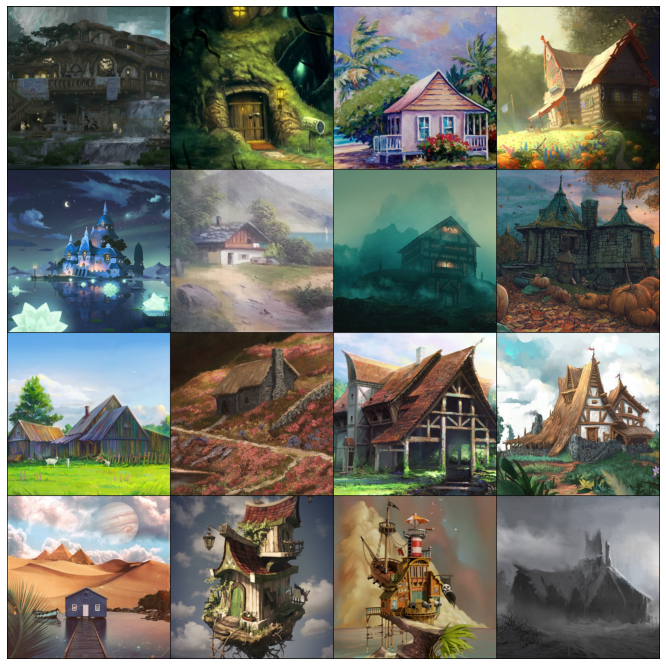

In [8]:
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

### Generator and discriminator

In [9]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, ngf*64, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(ngf*64),
    nn.ReLU(True),
    nn.ConvTranspose2d(ngf*64, ngf*32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ngf*32),
    nn.ReLU(True),
    nn.ConvTranspose2d(ngf*32, ngf*16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ngf*16),
    nn.ReLU(True),
    nn.ConvTranspose2d(ngf*16, ngf*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ngf*8),
    nn.ReLU(True),
    nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ngf*4),
    nn.ReLU(True),
    nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ngf*2),
    nn.ReLU(True),   
    nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(ngf),
    nn.ReLU(True),  
    nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1),
    nn.Tanh()
)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = SpectralNorm(nn.Conv2d(nc, ndf, 4, stride=2, padding=1))
        self.conv2 = SpectralNorm(nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1))
        self.conv3 = SpectralNorm(nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1))
        self.conv4 = SpectralNorm(nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1))
        self.conv5 = SpectralNorm(nn.Conv2d(ndf*8, ndf*16, kernel_size=4, stride=2, padding=1))
        self.conv6 = SpectralNorm(nn.Conv2d(ndf*16, ndf*32, kernel_size=4, stride=2, padding=1))
        self.conv66 = SpectralNorm(nn.Conv2d(ndf*32, ndf*64, kernel_size=4, stride=2, padding=1))
        self.conv7 = nn.Conv2d(ndf*64, 1, kernel_size=4, stride=1, padding=0)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leakyrelu(self.conv1(x))
        x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv3(x))
        x = self.leakyrelu(self.conv4(x))
        x = self.leakyrelu(self.conv5(x))
        x = self.leakyrelu(self.conv6(x))
        x = self.leakyrelu(self.conv66(x))
        x = self.flatten(self.conv7(x))
        x = self.sigmoid(x)
        
        return x

### Saving images, progress, losses, and scores:

In [23]:
def denorm(img_tensors):
    return img_tensors*stats[1][0]+stats[0][0]

def save_progress_image(idx):
    generator_images = (generator(latent.detach())).to('cpu')
    name = 'image-{0:0=5d}.png'.format(idx+current_epoch)
    save_image(denorm(generator_images),os.path.join(progressdir, name), nrow=4)
      
def save_histories(his):
    if os.path.exists(progressdir+'/histories.pt'):
        losses_g, losses_d, fake_pr, real_pr = torch.load(progressdir+'/histories.pt')
    else:
        losses_g, losses_d, fake_pr, real_pr = [],[],[],[]
        
    losses_g += his[0]
    losses_d += his[1]
    fake_pr += his[2]
    real_pr += his[3]
    histories = losses_g, losses_d, fake_pr, real_pr
    torch.save(histories, './'+progressdir+'/histories.pt')

def save_state():
    torch.save(generator.state_dict(), progressdir+'/G'+str(epochs+current_epoch)+'.pth')
    torch.save(discriminator.state_dict(), progressdir+'/D'+str(epochs+current_epoch)+'.pth')
    
def plot_losses():
    losses_g, losses_d, _, _ = torch.load(progressdir+'/histories.pt')
    plt.figure(figsize=(10,3))
    plt.plot(losses_d, '-')
    plt.plot(losses_g, '-')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Discriminator', 'Generator'])
    plt.title('Losses')  
      
def plot_scores():
    _, _, fake_pr, real_pr = torch.load(progressdir+'/histories.pt')
    plt.figure(figsize=(10,3))
    plt.plot(real_pr, '-')
    plt.plot(fake_pr, '-')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend(['Real', 'Fake'])
    plt.title('Scores')

Generate a latent vector for saving progress images and save generator output prior to training:

In [11]:
latent = torch.randn(batch_size,latent_size, 1, 1)
# torch.save(latent, 'saved_latent.pt')
# latent = torch.load('saved_latent.pt')

# save generator output prior to training:
save_progress_image(0)

# move latent to device:
latent = latent.to(device)

### Generator and discriminator training

In [12]:
def train_generator(optim_g, num_images):
    # Generate images with generator:
    latent = torch.randn(num_images, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Give discriminator generator images:
    preds = discriminator(DiffAugment(fake_images, policy=policy))
    targets = torch.ones(num_images, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update weights:
    loss.backward()
    optim_g.step()  
    return loss.item()

def train_discriminator(real_images, optim_d, num_images):
    # Give discriminator real images:
    real_preds = discriminator(DiffAugment(real_images, policy=policy))
    real_targets = (torch.ones(num_images, 1, device=device))#*(1-np.random.uniform(-0.1, 0.1)) #label smoothing (not used for imaginary houses model)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate images with generator:
    latent = torch.randn(num_images, latent_size, 1, 1, device=device)
    fake_images = generator(latent)  

    # Give discriminator generator images:
    fake_targets = torch.zeros(num_images, 1, device=device)
    fake_preds = discriminator(DiffAugment(fake_images, policy=policy))
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update weights:
    loss = real_loss + fake_loss
    loss.backward()
    optim_d.step()
    return loss.item(), real_score, fake_score

In [16]:
discriminator = Discriminator().to(device)
generator = generator.to(device)

def fit(epochs):
    gc.collect()
    torch.cuda.empty_cache()

    losses_g, losses_d, real_scores, fake_scores = [],[],[],[]
    
    # Optimizers:
    optim_d = AdaBelief(discriminator.parameters(), eps=1e-16, lr=lr, betas=(0.5, 0.999), 
                           weight_decay=0, 
                           weight_decouple=True, 
                           rectify=True,
                           fixed_decay=False,
                           amsgrad=False,
                           print_change_log = False)
    optim_g = AdaBelief(generator.parameters(), eps=1e-16, lr=lr, betas=(0.5, 0.999), 
                           weight_decay=0, 
                           weight_decouple=True, 
                           rectify=True,
                           fixed_decay=False,
                           amsgrad=False,
                           print_change_log = False)

    
    # Training:
    for e in range(epochs):
        for image, _ in tqdm(train_dataloader):
            num_images = image.size(0)
            optim_d.zero_grad()
            loss_d, real_score, fake_score = train_discriminator(image.to(device), optim_d, num_images)
            optim_g.zero_grad()
            loss_g = train_generator(optim_g, num_images)
            
        # Record losses and scores:    
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        fake_scores.append(fake_score)
        real_scores.append(real_score)
        
        # Print losses and scores for the last batch: 
        print("epoch: [{}/{}], loss_gen: {:.4f}, loss_disc: {:.4f}, fake_preds: {:.4f}, real_preds: {:.4f}".format(
            e+1, epochs, loss_g, loss_d, fake_score, real_score))
    
        # Save generated images every 5 epochs (or every epoch):
#         if (e+1)%5 == 0:
        save_progress_image(e+1)
        
    
    return losses_g, losses_d, fake_scores, real_scores

Train model for e.g. 5 epochs and save losses, scores, and weights at the end:

In [17]:
current_epoch = 0
epochs = 5
history = fit(epochs)
save_histories(history)
save_state()

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief



epoch: [1/5], loss_gen: 1.2585, loss_disc: 0.3696, fake_preds: 0.1888, real_preds: 0.8586



epoch: [2/5], loss_gen: 2.3107, loss_disc: 0.7442, fake_preds: 0.4020, real_preds: 1.0000



epoch: [3/5], loss_gen: 2.0530, loss_disc: 0.6232, fake_preds: 0.4615, real_preds: 0.9993



epoch: [4/5], loss_gen: 1.1420, loss_disc: 1.1422, fake_preds: 0.4023, real_preds: 0.5598



epoch: [5/5], loss_gen: 0.6788, loss_disc: 1.2967, fake_preds: 0.5357, real_preds: 0.5898


Plot losses and scores:

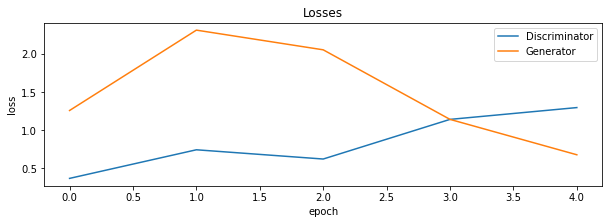

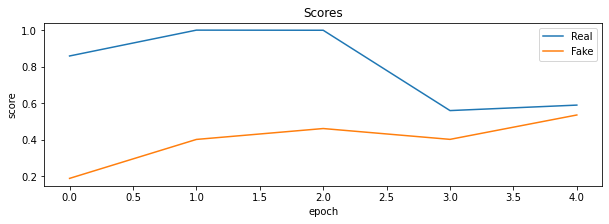

In [24]:
plot_losses()
plot_scores()